REV Object detect Model

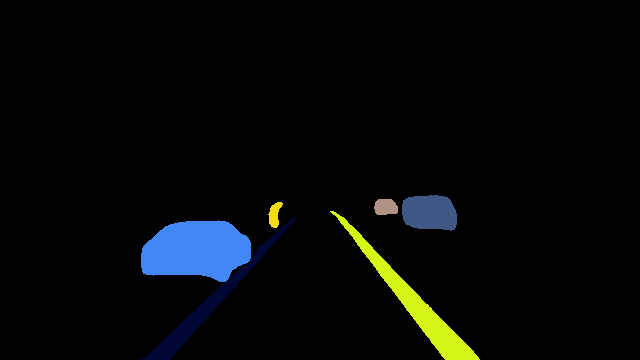

In [ ]:
from PIL import Image
import yaml
import os
import numpy as np
from label_manager import LabelManager
import torch


obj_entity_list = []
obj_entity_list.append({'Entity': 'Background', 'ID': 0, 'Colour': [0,0,0]})

with open("object.yaml", 'r') as file:
    config = yaml.safe_load(file)
    for ele in config['DRIVING_objects']:
        entity_map = {}
        entity_map['Entity'] = ele['Entity']
        entity_map['ID'] = ele['ID']
        entity_map['Colour'] = ele['Colour']
        obj_entity_list.append(entity_map)

colour_list = []

for entity in obj_entity_list:
    cur_colour = entity['Colour']
    colour_list += cur_colour

Image.open('input/4.jpg')

mask = Image.open('rev_mask/80.png')
# mask = np.array(mask)

# obj_ids = np.unique(mask)
# # first id is the background, so remove it
# obj_ids = obj_ids[1:]
# print(obj_ids)

# print('mask shape', mask.shape)

# label_manager = LabelManager()
# label_num = label_manager.get_num()
# mask_label = np.zeros((label_num, mask.shape[0], mask.shape[1]), np.uint8)
# print('mask_label', mask_label.shape)

# # instances are encoded as different colors
# obj_ids = np.unique(mask)
# # first id is the background, so remove it
# obj_ids = obj_ids[1:]
# print('obj_ids', obj_ids)

# print('obj_ids [1][None][None]', obj_ids[1, None, None])

# for i, id in enumerate(obj_ids):
#     mask_label[id] = mask == obj_ids[i, None, None]
#     print('obj_ids(i)', obj_ids[i, None, None])

# masks = mask == obj_ids[:, None, None]

# print('masks: ', masks.shape)
# labels = torch.ones((1,), dtype=torch.int64)
# print('labels', labels)
# labels = torch.as_tensor(obj_ids, dtype=torch.int64)
# print('labels', labels)





mask.putpalette(
    [
        0, 0, 0,
        66, 135, 245,
        10, 46, 110,
        63, 89, 132,
        174, 146, 132,
        243, 221, 18,
        1, 7, 53,
        215, 245, 22,
        
    ]
)
mask

# reference_mask = Image.open('FudanPed00001_mask.png')
# reference_mask.getpixel


In [36]:
import yaml
with open('mask/0.yaml', 'r') as file:
    config = yaml.safe_load(file)

print(config)
label_list = list(config.values())

mask = np.array(mask)

obj_ids = np.unique(mask)
# first id is the background, so remove it
obj_ids = obj_ids[1:]
labels = torch.as_tensor(label_list, dtype=torch.int64)
print(obj_ids)
print(labels)

masks = mask == obj_ids[:, None, None]
print(masks.shape)
num_objs = len(obj_ids)
boxes = []
for i in range(num_objs):
    pos = np.where(masks[i])
    xmin = np.min(pos[1])
    xmax = np.max(pos[1])
    ymin = np.min(pos[0])
    ymax = np.max(pos[0])
    boxes.append([xmin, ymin, xmax, ymax])
boxes = torch.as_tensor(boxes, dtype=torch.float32)
print(boxes.shape)
labels = torch.as_tensor(labels, dtype=torch.int64)
masks = torch.as_tensor(masks, dtype=torch.uint8)
print(labels)
print(masks.shape)

image_id = torch.tensor([0])
area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
# suppose all instances are not crowd
iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
print(image_id)
print(iscrowd)
print(area.shape)


{1: 1, 2: 1, 3: 1, 4: 1, 5: 10, 6: 10, 7: 4}
[1 2 3 4 5 6 7]
tensor([ 1,  1,  1,  1, 10, 10,  4])
(7, 360, 640)
torch.Size([7, 4])
tensor([ 1,  1,  1,  1, 10, 10,  4])
torch.Size([7, 360, 640])
tensor([0])
tensor([0, 0, 0, 0, 0, 0, 0])
torch.Size([7])


In [ ]:
import os
import numpy as np
import torch
from PIL import Image

class RevDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        
        self.imgs = list(sorted(os.listdir('input/')))
        self.masks = list(sorted(os.listdir('mask/')))
        
    def __getitem__(self, index):
        img_path = os.path.join('input/', self.imgs[index])
        mask_path = os.path.join('mask/', self.masks[index])
        
        img = Image.open(img_path).convert("L")
        mask = Image.open(mask_path)
        
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        
        # split the color-encoded mask into a set of binary masks
        masks = mask == obj_ids[:, None, None]
        
        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([index])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        # print(target)


        return img, target
        
    def __len__(self):
        return len(self.imgs)

    
        

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def build_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn()

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Stop here if you are fine-tunning Faster-RCNN

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [ ]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

In [ ]:

import transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [ ]:
from engine import train_one_epoch, evaluate
import utils


def main():
    # train on the GPU or on the CPU, if a GPU is not available
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # our dataset has 3 classes only - background, vehicle road lane
    num_classes = 3
    # use our dataset and defined transformations
    dataset = RevDataset('PennFudanPed', get_transform(train=True))
    dataset_test = RevDataset('PennFudanPed', get_transform(train=False))

    # split the dataset in train and test set
    indices = torch.randperm(len(dataset)).tolist()
    dataset = torch.utils.data.Subset(dataset, indices[:-50])
    dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

    # define training and validation data loaders
    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=2, shuffle=True, num_workers=4,
        collate_fn=utils.collate_fn)

    data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=1, shuffle=False, num_workers=4,
        collate_fn=utils.collate_fn)

    # get the model using our helper function
    model = build_model(num_classes)
    print('build mode done')

    # move model to the right device
    model.to(device)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)

    # let's train it for 5 epochs
    num_epochs = 5
    print('Lets train the model')
    for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        evaluate(model, data_loader_test, device=device)

    print("That's it!")
    
main()

In [ ]:
torch.save(model, 'mask-rcnn-pedestrian.pt')

# set to evaluation mode
model.eval()
CLASS_NAMES = ['__background__', 'car']
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)



In [ ]:
%matplotlib inline
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import torchvision
import numpy as np

import cv2
import random
import warnings
warnings.filterwarnings('ignore')

def get_coloured_mask(mask):
    """
    random_colour_masks
      parameters:
        - image - predicted masks
      method:
        - the masks of each predicted object is given random colour for visualization
    """
    colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    r[mask == 1], g[mask == 1], b[mask == 1] = colours[random.randrange(0,10)]
    coloured_mask = np.stack([r, g, b], axis=2)
    return coloured_mask

def get_prediction(img_path, confidence):
    """
    get_prediction
      parameters:
        - img_path - path of the input image
        - confidence - threshold to keep the prediction or not
      method:
        - Image is obtained from the image path
        - the image is converted to image tensor using PyTorch's Transforms
        - image is passed through the model to get the predictions
        - masks, classes and bounding boxes are obtained from the model and soft masks are made binary(0 or 1) on masks
          ie: eg. segment of cat is made 1 and rest of the image is made 0
    
    """
    img = Image.open(img_path)
    transform = T.Compose([T.ToTensor()])
    img = transform(img)

    img = img.to(device)
    pred = model([img])
    
    # print('hg84---', pred[0].keys())
    for cur_p in pred:
        print('hg84', cur_p['scores'])

    pred_score = list(pred[0]['scores'].detach().cpu().numpy())
    pred_t = [pred_score.index(x) for x in pred_score if x>confidence][-1]
    masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
    # print(pred[0]['labels'].numpy().max())
    pred_class = [CLASS_NAMES[i] for i in list(pred[0]['labels'].cpu().numpy())]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())]
    masks = masks[:pred_t+1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    return masks, pred_boxes, pred_class
    # return pred_boxes, pred_class

def segment_instance(img_path, confidence=0.5, rect_th=2, text_size=2, text_th=2):
    """
    segment_instance
      parameters:
        - img_path - path to input image
        - confidence- confidence to keep the prediction or not
        - rect_th - rect thickness
        - text_size
        - text_th - text thickness
      method:
        - prediction is obtained by get_prediction
        - each mask is given random color
        - each mask is added to the image in the ration 1:0.8 with opencv
        - final output is displayed
    """
    masks, boxes, pred_cls = get_prediction(img_path, confidence)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for i in range(len(boxes)):
      rgb_mask = get_coloured_mask(masks[i])
      img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
      print(boxes[i])
      pt1 = tuple([int(j) for j in boxes[i][0]])
      pt2 = tuple([int(j) for j in boxes[i][1]])
      cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th)
      cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
    plt.figure(figsize=(20,30))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

segment_instance('input/50.jpg')